In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
from datetime import datetime as dt
import seaborn as sns
import folium
import json
import geopandas as gpd

In [2]:
# Function that combines the DataFrame for each week.

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" #url with formatting to fill in the number of the particular week
    dfs = []
    for week_num in week_nums: #for each week
        file_url = url.format(week_num) #format the url so it grabs that week
        dfs.append(pd.read_csv(file_url)) #append to our empty list
    return pd.concat(dfs) #combine files for each week

In [3]:
# Suffix of text file signifying Year(2021), Month(03 - March), and day(06)

week_nums = [210306, 210313, 210320, 210327, 210403, 210410, 210417, 210424, 210501, 210508, 210515]
#210227
turnstiles_df = get_data(week_nums)               #use our function to get a df with all of our data

turnstiles_df.to_csv('mta_data_all.csv', header = False, index = False)

cols = ['CA','UNIT', 'SCP','STATION','LINE','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
mta_data = pd.read_csv('mta_data_all.csv', names = cols) # Data frame with combined data
mta_data.shape

(2299530, 11)

In [4]:
# Strip leading/trailing spaces in column name if available

mta_data.columns = [column.strip() for column in mta_data.columns]

In [5]:
# 11 weeks of Data

mta_data.DATE.value_counts().sort_index()

02/27/2021    29985
02/28/2021    29763
03/01/2021    29868
03/02/2021    29803
03/03/2021    29871
              ...  
05/10/2021    29931
05/11/2021    29849
05/12/2021    29877
05/13/2021    29982
05/14/2021    29761
Name: DATE, Length: 77, dtype: int64

In [6]:
# Take the date and time fields into a single datetime column
# DATE_TIME has a datetime data type and we can do date time manipulations

mta_data["DATE_TIME"] = pd.to_datetime(mta_data.DATE + " " + mta_data.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")
mta_data.head()

,CA,UNIT,SCP,STATION,LINE,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,03:00:00,REGULAR,7537255,2570434,2021-02-27 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,07:00:00,REGULAR,7537260,2570445,2021-02-27 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,11:00:00,REGULAR,7537285,2570500,2021-02-27 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,15:00:00,REGULAR,7537354,2570546,2021-02-27 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,19:00:00,REGULAR,7537501,2570582,2021-02-27 19:00:00


In [7]:
# An MTA subway turnstile can be identified by a combination of CA/UNIT/STATION

mask = ((mta_data["CA"] == "A002") &
        (mta_data["UNIT"] == "R051") & 
        (mta_data["SCP"] == "02-00-00") & 
        (mta_data["STATION"] == "59 ST"))

mta_data[mask].head()

,CA,UNIT,SCP,STATION,LINE,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,03:00:00,REGULAR,7537255,2570434,2021-02-27 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,07:00:00,REGULAR,7537260,2570445,2021-02-27 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,11:00:00,REGULAR,7537285,2570500,2021-02-27 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,15:00:00,REGULAR,7537354,2570546,2021-02-27 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/27/2021,19:00:00,REGULAR,7537501,2570582,2021-02-27 19:00:00


In [8]:
# Verify that each turnstile entry for "CA", "UNIT", "SCP", "STATION", "DATE_TIME" is unique

(mta_data
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
705025,N100,R252,00-00-00,HIGH ST,2021-03-09 07:00:00,2
194966,B024,R211,00-05-00,KINGS HWY,2021-05-04 08:00:00,2
194970,B024,R211,00-05-00,KINGS HWY,2021-05-05 00:00:00,2
957031,N329,R201,00-03-02,WOODHAVEN BLVD,2021-05-08 01:00:00,2
957032,N329,R201,00-03-02,WOODHAVEN BLVD,2021-05-08 05:00:00,2


In [9]:
# On 3/9/21, we seem to have two entries for same time.  
# Print details for that day to identify the duplicate row.

mask = ((mta_data["CA"] == "N100") & 
(mta_data["UNIT"] == "R252") & 
(mta_data["SCP"] == "00-00-00") & 
(mta_data["STATION"] == "HIGH ST") &
(mta_data["DATE_TIME"].dt.date == datetime.datetime(2021, 3, 9).date()))

mta_data[mask].head()

,CA,UNIT,SCP,STATION,LINE,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
273275,N100,R252,00-00-00,HIGH ST,AC,IND,03/09/2021,03:00:00,REGULAR,818043,1730673,2021-03-09 03:00:00
273276,N100,R252,00-00-00,HIGH ST,AC,IND,03/09/2021,03:00:00,RECOVR AUD,818272,1731687,2021-03-09 03:00:00
273277,N100,R252,00-00-00,HIGH ST,AC,IND,03/09/2021,07:00:00,REGULAR,818050,1730744,2021-03-09 07:00:00
273278,N100,R252,00-00-00,HIGH ST,AC,IND,03/09/2021,07:00:00,RECOVR AUD,818272,1731687,2021-03-09 07:00:00
273279,N100,R252,00-00-00,HIGH ST,AC,IND,03/09/2021,11:00:00,REGULAR,818117,1731066,2021-03-09 11:00:00


In [10]:
# Data frame above shows that the duplicate row is a RECOVERY AUDIT entry.
# Notice that ENTRIES and EXITS for the RECOVR AUD row is slightly different from the values in the REGULAR row.

mta_data.DESC.value_counts()

REGULAR       2290848
RECOVR AUD       8682
Name: DESC, dtype: int64

In [11]:
# Get rid of the duplicate entry

mta_data.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
mta_data.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [12]:
# Verify that each turnstile entry for "CA", "UNIT", "SCP", "STATION", "DATE_TIME" is unique

(mta_data
 .groupby(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,CA,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-02-27 03:00:00,1
1532972,R138,R293,00-05-01,34 ST-PENN STA,2021-03-21 10:00:00,1
1532966,R138,R293,00-05-01,34 ST-PENN STA,2021-03-20 10:00:00,1
1532967,R138,R293,00-05-01,34 ST-PENN STA,2021-03-20 14:00:00,1
1532968,R138,R293,00-05-01,34 ST-PENN STA,2021-03-20 18:00:00,1


In [13]:
# Each combination of C/A, UNIT, SCP, and STATION represents a unique turnstile. 
# Let's take a look at a specific turnstile on a specific date.
# The ENTRIES/EXITS column represents cumulative ENTRIES/EXITS at that point in time.

mta_data[(mta_data["CA"] == "A011") & 
(mta_data["UNIT"] == "R080") & 
(mta_data["SCP"] == "01-00-00") & 
(mta_data["STATION"] == "57 ST-7 AV") &
(mta_data["DATE"] == "03/27/2021")]

,CA,UNIT,SCP,STATION,LINE,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
836405,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,03/27/2021,20:00:00,REGULAR,483958,1615828,2021-03-27 20:00:00
836404,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,03/27/2021,16:00:00,REGULAR,483923,1615796,2021-03-27 16:00:00
836403,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,03/27/2021,12:00:00,REGULAR,483909,1615769,2021-03-27 12:00:00
836402,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,03/27/2021,08:00:00,REGULAR,483894,1615748,2021-03-27 08:00:00
836401,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,03/27/2021,04:00:00,REGULAR,483893,1615744,2021-03-27 04:00:00
836400,A011,R080,01-00-00,57 ST-7 AV,NQRW,BMT,03/27/2021,00:00:00,REGULAR,483889,1615738,2021-03-27 00:00:00


In [15]:
# The maximum ENTRIES value would occur at the last reading of the day. 
# Since rows are listed in descending order of time, we can grab the last 
# reading of the day (located at the top of the group) using the .first() DataFrame method.
# This shows max daily ENTRIES
# as_index=False keeps original data structure. There will be no need to flatten the file using reset_index()

mta_data_daily = (mta_data
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        [['ENTRIES','EXITS', "DATE_TIME"]].first())
mta_data_daily.head()

,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,02/27/2021,7537589,2570596,2021-02-27 23:00:00
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,2570717,2021-02-28 23:00:00
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,2570968,2021-03-01 23:00:00
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,2571211,2021-03-02 23:00:00
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,2571472,2021-03-03 23:00:00


In [16]:
# Add new columns to the dataframe. For each row, fill with values from the previous day using shift(1).

mta_data_daily[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (mta_data_daily
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES", "EXITS"]]
                                                       .shift(1))
mta_data_daily.head()

,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,02/27/2021,7537589,2570596,2021-02-27 23:00:00,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,2570717,2021-02-28 23:00:00,02/27/2021,7537589.0,2570596.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,2570968,2021-03-01 23:00:00,02/28/2021,7537852.0,2570717.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,2571211,2021-03-02 23:00:00,03/01/2021,7538400.0,2570968.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,2571472,2021-03-03 23:00:00,03/02/2021,7538926.0,2571211.0


In [17]:
# Drop the row for the earliest date in the df

mta_data_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [18]:
# Exploring the ENTRIES field

(mta_data_daily["ENTRIES"] - mta_data_daily["PREV_ENTRIES"]).describe()

count    3.794350e+05
mean    -4.808390e+03
std      7.101278e+06
min     -1.604323e+09
25%      6.000000e+01
50%      2.160000e+02
75%      4.450000e+02
max      2.139011e+09
dtype: float64

In [19]:
# Notice that some rows are backwards

mta_data_daily[mta_data_daily["ENTRIES"] < mta_data_daily["PREV_ENTRIES"]].shape

(3521, 11)

In [20]:
# Print some of this data where entry PREV_ENTRIES are larger than ENTRIES

mta_data_daily[mta_data_daily["ENTRIES"] < mta_data_daily["PREV_ENTRIES"]].head()

,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS
331,A002,R051,02-03-02,59 ST,03/22/2021,238,88,2021-03-22 20:00:00,03/21/2021,6641395.0,8869456.0
3004,A011,R080,01-03-00,57 ST-7 AV,02/28/2021,885620240,489658315,2021-02-28 23:00:00,02/27/2021,885620355.0,489658832.0
3005,A011,R080,01-03-00,57 ST-7 AV,03/01/2021,885620021,489657460,2021-03-01 23:00:00,02/28/2021,885620240.0,489658315.0
3006,A011,R080,01-03-00,57 ST-7 AV,03/02/2021,885619834,489656586,2021-03-02 23:00:00,03/01/2021,885620021.0,489657460.0
3007,A011,R080,01-03-00,57 ST-7 AV,03/03/2021,885619673,489655757,2021-03-03 19:00:00,03/02/2021,885619834.0,489656586.0


In [21]:
# Look at the entries at a turnstile with reverse entry and plot the ENTRIES

mask = ((mta_data["CA"] == "A011") & 
(mta_data["UNIT"] == "R080") & 
(mta_data["SCP"] == "01-03-00") & 
(mta_data["STATION"] == "57 ST-7 AV") &
(mta_data["DATE_TIME"].dt.date == datetime.date(2021, 2, 27)))

tmp1 = mta_data[mask].sort_values('DATE_TIME')[['DATE', 'TIME', 'ENTRIES', 'EXITS']]
tmp1

,DATE,TIME,ENTRIES,EXITS
1638,02/27/2021,03:00:00,885620487,489659546
1639,02/27/2021,07:00:00,885620487,489659520
1640,02/27/2021,11:00:00,885620476,489659357
1641,02/27/2021,15:00:00,885620459,489659122
1642,02/27/2021,19:00:00,885620391,489658918
1643,02/27/2021,23:00:00,885620355,489658832


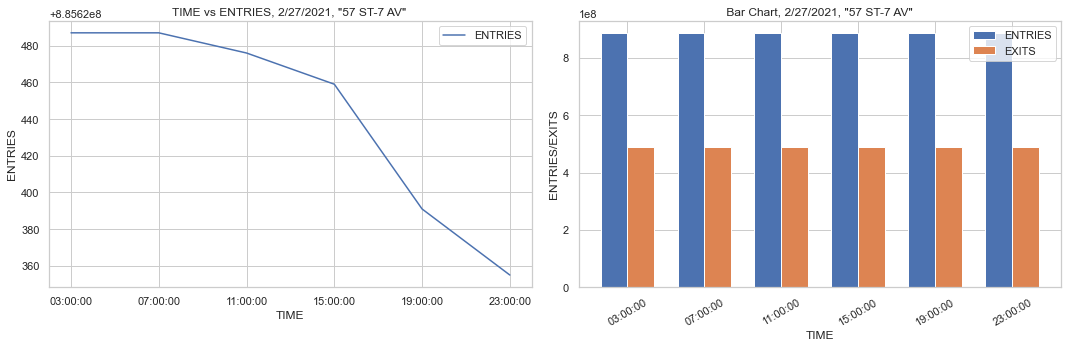

In [23]:
# Distribution of ENTRIES and EXITS
# Notice that the cumulative ENTRIES is going down. This shows that the counter is counting in reverse.

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1,2,figsize=[15,5])
ax[0].plot(tmp1['TIME'],tmp1['ENTRIES'], label='ENTRIES')
ax[0].set_title('TIME vs ENTRIES, 2/27/2021, "57 ST-7 AV" ')
ax[0].set_ylabel('ENTRIES')
ax[0].set_xlabel('TIME')
ax[0].legend()

x_index = np.arange(tmp1.TIME.count())
wtmp1 = 0.35
ax[1].set_xticks(ticks=x_index)
rect1 = ax[1].bar(x_index - wtmp1/2,tmp1['ENTRIES'],width=wtmp1,label='ENTRIES') #color='orange'
rect2 = ax[1].bar(x_index + wtmp1/2,tmp1['EXITS'],width=wtmp1,label='EXITS') #color='blue'
ax[1].set_title(' Bar Chart, 2/27/2021, "57 ST-7 AV" ')
ax[1].set_ylabel('ENTRIES/EXITS')
ax[1].set_xlabel('TIME')
ax[1].set_xticklabels(tmp1['TIME'],rotation = 30, horizontalalignment = 'center' )
ax[1].legend()

fig.tight_layout()

In [24]:
# The reverse counter can be fixed by sorting the ENTRIES and EXITS columns, individually, in ascending order.
# Unhide the next two columns to show reversed order in ENTRIES and EXITS.
# We can do this for all 3521 rows that are backwards.

tmp1['ENTRIES'] = tmp1['ENTRIES'].sort_values(ascending=True).values
tmp1['EXITS'] = tmp1['EXITS'].sort_values(ascending=True).values

tmp1[["PREV_TIME", "PREV_ENTRIES","PREV_EXITS"]] = (tmp1
                                                   .groupby(["DATE"])[["TIME", "ENTRIES", "EXITS"]]
                                                   .shift(1))
tmp1['ENTRIES_DIFF'] = tmp1["ENTRIES"] - tmp1["PREV_ENTRIES"]
tmp1['EXITS_DIFF'] = tmp1["EXITS"] - tmp1["PREV_EXITS"]
tmp1

,DATE,TIME,ENTRIES,EXITS,PREV_TIME,PREV_ENTRIES,PREV_EXITS,ENTRIES_DIFF,EXITS_DIFF
1638,02/27/2021,03:00:00,885620355,489658832,NaN,NaN,NaN,NaN,NaN
1639,02/27/2021,07:00:00,885620391,489658918,03:00:00,885620355.0,489658832.0,36.0,86.0
1640,02/27/2021,11:00:00,885620459,489659122,07:00:00,885620391.0,489658918.0,68.0,204.0
1641,02/27/2021,15:00:00,885620476,489659357,11:00:00,885620459.0,489659122.0,17.0,235.0
1642,02/27/2021,19:00:00,885620487,489659520,15:00:00,885620476.0,489659357.0,11.0,163.0
1643,02/27/2021,23:00:00,885620487,489659546,19:00:00,885620487.0,489659520.0,0.0,26.0


In [25]:
# Returning to mta_data_daily
# Identify stations with the reverse counting issues.
(mta_data_daily[mta_data_daily["ENTRIES"] < mta_data_daily["PREV_ENTRIES"]]
    .groupby(["CA", "UNIT", "SCP", "STATION"])
    .size())

CA    UNIT  SCP       STATION        
A002  R051  02-03-02  59 ST               1
A011  R080  01-03-00  57 ST-7 AV         76
            01-03-03  57 ST-7 AV          1
            01-03-04  57 ST-7 AV          1
A025  R023  01-06-00  34 ST-HERALD SQ     1
                                         ..
R617  R058  00-00-02  BERGEN ST           1
R622  R123  00-00-00  FRANKLIN AV        75
R624  R124  00-00-02  KINGSTON AV         1
R730  R431  00-00-04  EASTCHSTER/DYRE    76
S101  R070  00-00-04  ST. GEORGE          1
Length: 193, dtype: int64

In [27]:
# For further analysis, create temporary Columns for daily entries and exits at each turnstile 
#
# Total Daily activity (ENTRIES and EXITS) at a turnstile 
# Assuming 60 persons per minute per turnstile
# This is 3600 persons per 1 hours, 14400 per 4 hours
# That is 86400 DAILY_ACTIVITY (43200 ENTRIES and 43200 EXITS) per turnstile. Total entries and exits from a turnstile per day
#
# We can safely assume that at the busiest turnstile, the sum of tmp_d_entries and tmp_d_exits is <= 86400
# All other values outside this window will be considered outliers.
# We will use the 99th percentile in this case because the values make sence. The outliers are in the max/min.

mta_data_daily['tmp_d_entries'] = mta_data_daily["ENTRIES"] - mta_data_daily["PREV_ENTRIES"]
mta_data_daily['tmp_d_exits'] = mta_data_daily["EXITS"] - mta_data_daily["PREV_EXITS"]

print(mta_data_daily.tmp_d_entries.describe())
print('*** 99th Percentile_Entries = ', mta_data_daily.tmp_d_entries.quantile(0.99)) # Take the 99th percentile, = 1444

print(mta_data_daily.tmp_d_exits.describe())
print('*** 99th Percentile_Exits = ', mta_data_daily.tmp_d_exits.quantile(0.99)) # Take the 99th percentile, = 1868

mta_data_daily.head()

count    3.794350e+05
mean    -4.808390e+03
std      7.101278e+06
min     -1.604323e+09
25%      6.000000e+01
50%      2.160000e+02
75%      4.450000e+02
max      2.139011e+09
Name: tmp_d_entries, dtype: float64
*** 99th Percentile_Entries =  1444.0
count    3.794350e+05
mean    -3.454682e+03
std      6.743575e+06
min     -1.804895e+09
25%      5.800000e+01
50%      2.000000e+02
75%      4.600000e+02
max      2.005379e+09
Name: tmp_d_exits, dtype: float64
*** 99th Percentile_Exits =  1868.0


,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,tmp_d_entries,tmp_d_exits
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,2570717,2021-02-28 23:00:00,02/27/2021,7537589.0,2570596.0,263.0,121.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,2570968,2021-03-01 23:00:00,02/28/2021,7537852.0,2570717.0,548.0,251.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,2571211,2021-03-02 23:00:00,03/01/2021,7538400.0,2570968.0,526.0,243.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,2571472,2021-03-03 23:00:00,03/02/2021,7538926.0,2571211.0,577.0,261.0
5,A002,R051,02-00-00,59 ST,03/04/2021,7540040,2571750,2021-03-04 23:00:00,03/03/2021,7539503.0,2571472.0,537.0,278.0


In [28]:
# Drop temporary columns ['tmp_d_entries','tmp_d_exits']

mta_data_daily = mta_data_daily.drop(["tmp_d_entries", "tmp_d_exits"], axis=1, errors="ignore")
print(mta_data_daily.shape)
mta_data_daily.head()

(379435, 11)


,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,2570717,2021-02-28 23:00:00,02/27/2021,7537589.0,2570596.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,2570968,2021-03-01 23:00:00,02/28/2021,7537852.0,2570717.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,2571211,2021-03-02 23:00:00,03/01/2021,7538400.0,2570968.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,2571472,2021-03-03 23:00:00,03/02/2021,7538926.0,2571211.0
5,A002,R051,02-00-00,59 ST,03/04/2021,7540040,2571750,2021-03-04 23:00:00,03/03/2021,7539503.0,2571472.0


In [29]:
# METIS function to efficiently handle backward counters. 
# USE THIS FUNCTION TO GET THE DAILY_ENTRIES

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        #print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

# USE THIS FUNCTION TO GET THE DAILY EXITS

def get_daily_counts_exit(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        #print(f'exits: {row["EXITS"]} <-- {row["PREV_EXITS"]}')
        counter = min(row["EXITS"], row["PREV_EXITS"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

In [30]:
# *** 99th Percentile_Entries =  1444.0

mta_data_daily["DAILY_ENTRIES"] = mta_data_daily.apply(get_daily_counts, axis=1, max_counter=1444) # max_counter_def

# *** 99th Percentile_Exits =  1868.0

mta_data_daily["DAILY_EXITS"] = mta_data_daily.apply(get_daily_counts_exit, axis=1, max_counter=1868) # max_counter_default = 1000000

print('Shape of mta_data_daily: ',mta_data_daily.shape)
mta_data_daily.head()

Shape of mta_data_daily:  (379435, 13)


,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,2570717,2021-02-28 23:00:00,02/27/2021,7537589.0,2570596.0,263.0,121.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,2570968,2021-03-01 23:00:00,02/28/2021,7537852.0,2570717.0,548.0,251.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,2571211,2021-03-02 23:00:00,03/01/2021,7538400.0,2570968.0,526.0,243.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,2571472,2021-03-03 23:00:00,03/02/2021,7538926.0,2571211.0,577.0,261.0
5,A002,R051,02-00-00,59 ST,03/04/2021,7540040,2571750,2021-03-04 23:00:00,03/03/2021,7539503.0,2571472.0,537.0,278.0


In [31]:
# DAILY ACTIVITY is the sum of DAILY_ENTRIES and DAILY EXITS
# Note that total subway ridership is define based on DAILY_ENTRIES.
# We are considering DAILLY_ACTIVITY to ensure that we capture everyone that is going through the station.

mta_data_daily['DAILY_ACTIVITY'] = mta_data_daily["DAILY_ENTRIES"] + mta_data_daily["DAILY_EXITS"]
mta_data_daily.head()

,CA,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
1,A002,R051,02-00-00,59 ST,02/28/2021,7537852,2570717,2021-02-28 23:00:00,02/27/2021,7537589.0,2570596.0,263.0,121.0,384.0
2,A002,R051,02-00-00,59 ST,03/01/2021,7538400,2570968,2021-03-01 23:00:00,02/28/2021,7537852.0,2570717.0,548.0,251.0,799.0
3,A002,R051,02-00-00,59 ST,03/02/2021,7538926,2571211,2021-03-02 23:00:00,03/01/2021,7538400.0,2570968.0,526.0,243.0,769.0
4,A002,R051,02-00-00,59 ST,03/03/2021,7539503,2571472,2021-03-03 23:00:00,03/02/2021,7538926.0,2571211.0,577.0,261.0,838.0
5,A002,R051,02-00-00,59 ST,03/04/2021,7540040,2571750,2021-03-04 23:00:00,03/03/2021,7539503.0,2571472.0,537.0,278.0,815.0


In [32]:
mta_data_daily.DAILY_ACTIVITY.describe()

count    379435.000000
mean        605.140193
std         543.586804
min           0.000000
25%         178.000000
50%         477.000000
75%         891.000000
max        3299.000000
Name: DAILY_ACTIVITY, dtype: float64

In [33]:
# Group by Unique station turnstile is CA/UNIT/STATION

ca_unit_station_daily = mta_data_daily.groupby(["CA", "UNIT", "STATION", "DATE"]) \
                       [['DAILY_ENTRIES','DAILY_EXITS','DAILY_ACTIVITY']].sum().reset_index()
ca_unit_station_daily.head()

,CA,UNIT,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
0,A002,R051,59 ST,02/28/2021,2002.0,1554.0,3556.0
1,A002,R051,59 ST,03/01/2021,4187.0,3425.0,7612.0
2,A002,R051,59 ST,03/02/2021,4459.0,3541.0,8000.0
3,A002,R051,59 ST,03/03/2021,4575.0,3808.0,8383.0
4,A002,R051,59 ST,03/04/2021,4526.0,3633.0,8159.0


In [34]:
ca_unit_station_daily.DAILY_ACTIVITY.describe()

count    56924.000000
mean      4033.647829
std       3333.701424
min          0.000000
25%       1775.000000
50%       3210.000000
75%       5301.000000
max      32834.000000
Name: DAILY_ACTIVITY, dtype: float64

In [35]:
# Sort the DAILY_ACTIVITY and notice that at the busiest turnstile, the value is less than 86400 (1person/second)

ca_unit_station_daily.sort_values("DAILY_ACTIVITY", ascending=False).head()

,CA,UNIT,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
34959,PTH22,R540,PATH NEW WTC,05/14/2021,16673.0,16161.0,32834.0
34957,PTH22,R540,PATH NEW WTC,05/12/2021,15899.0,16040.0,31939.0
34958,PTH22,R540,PATH NEW WTC,05/13/2021,15882.0,15787.0,31669.0
34956,PTH22,R540,PATH NEW WTC,05/11/2021,16031.0,15626.0,31657.0
34952,PTH22,R540,PATH NEW WTC,05/07/2021,16070.0,15558.0,31628.0


In [42]:
# Daily time series for each station

station_daily = mta_data_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES','DAILY_EXITS','DAILY_ACTIVITY']] \
                .sum().reset_index()

Total_Days = len(station_daily.DATE.unique())
print('\nTotal Days = ', Total_Days)
station_daily.head()


Total Days =  76


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
0,1 AV,02/28/2021,3639.0,6155.0,9794.0
1,1 AV,03/01/2021,6086.0,9311.0,15397.0
2,1 AV,03/02/2021,6254.0,9793.0,16047.0
3,1 AV,03/03/2021,6557.0,8120.0,14677.0
4,1 AV,03/04/2021,6506.0,8248.0,14754.0


In [43]:
# Station with the highest traffic within the 11-week period (76 Days)

station_totals = station_daily.groupby('STATION')['DAILY_ACTIVITY'].sum() \
    .reset_index() \
    .sort_values('DAILY_ACTIVITY', ascending=False)

station_totals['AVG_DAILY_ACTIVITY'] = (station_totals['DAILY_ACTIVITY']*(1/Total_Days)).round(0)
print('Total Number of Subway Stations: ', station_totals.STATION.count())
station_totals.head()

Total Number of Subway Stations:  378


,STATION,DAILY_ACTIVITY,AVG_DAILY_ACTIVITY
61,34 ST-PENN STA,5243508.0,68994.0
110,86 ST,3860315.0,50794.0
59,34 ST-HERALD SQ,3853764.0,50707.0
9,125 ST,3750103.0,49343.0
46,23 ST,3602981.0,47408.0


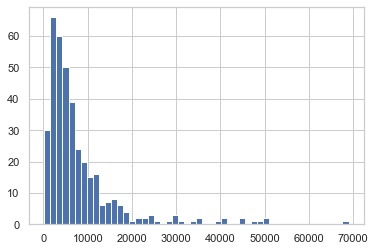

In [44]:
plt.hist(station_totals['AVG_DAILY_ACTIVITY'],50);

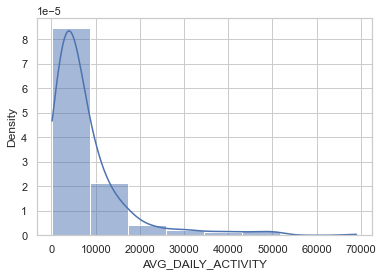

In [45]:
sns.histplot(station_totals['AVG_DAILY_ACTIVITY'], kde=True,bins=8, stat='density');

In [46]:
# View total daily subway entries
# Ridership is usually between 2M and 6M
# MTA reported a total of 2.27 Million riders on 5/14/2021

all_station_daily_entries = station_daily.groupby(["DATE"]) \
                       [['DAILY_ENTRIES']].sum().reset_index()
print(all_station_daily_entries.describe())
all_station_daily_entries.sort_values('DAILY_ENTRIES', ascending=False).head() # max daily entry.  == friday before BOOTCAMP

       DAILY_ENTRIES
count   7.600000e+01
mean    1.462480e+06
std     3.050213e+05
min     7.412890e+05
25%     1.246178e+06
50%     1.595284e+06
75%     1.679530e+06
max     1.792085e+06


,DATE,DAILY_ENTRIES
75,05/14/2021,1792085.0
68,05/07/2021,1777297.0
67,05/06/2021,1774165.0
73,05/12/2021,1766051.0
72,05/11/2021,1754742.0


Text(0.5, 0, 'DATE')

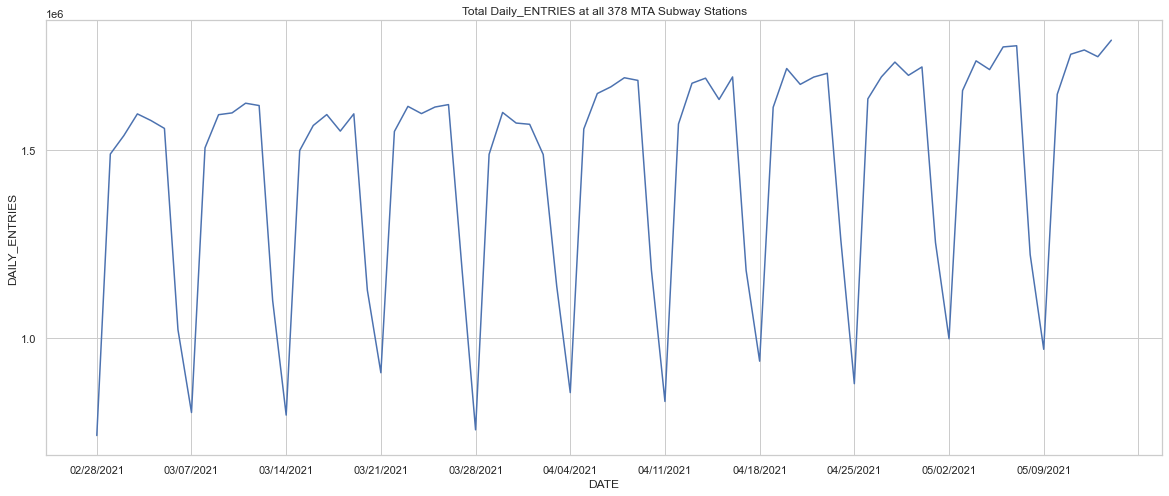

In [47]:
# Plot of DATE vs DAILY_ENTRIES
#
# Notice that subway activity has been increasing since the begining of this year 2021
# Due to the light restrictions after COVID-19, we expect the increasing trend to normalize between 2M and 6M DAILY ENTRIES
# From the graph, weekends have the sharp drop in DAILY_ENTRIES
# The dips in ENTRIES that occur during the week could be attributed to MTA counter reset/Data Cleaning.

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=[20,8])
ax.plot(all_station_daily_entries['DATE'],all_station_daily_entries['DAILY_ENTRIES'])
ax.yaxis.set_major_locator(ticker.MultipleLocator(500000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_title('Total Daily_ENTRIES at all 378 MTA Subway Stations')
ax.set_ylabel('DAILY_ENTRIES')
ax.set_xlabel('DATE')

In [48]:
# See details of activities at the turnstile with the maximum DAILY_ACTIVITY

mask = ((ca_unit_station_daily["CA"] == "PTH22") & 
        (ca_unit_station_daily["UNIT"] == "R540") & 
        (ca_unit_station_daily["STATION"] == "PATH NEW WTC"))

In [49]:
turnstile_max_daily_activity= ca_unit_station_daily[mask].sort_values('DATE')[['DATE', 'DAILY_ENTRIES', 'DAILY_EXITS', 'DAILY_ACTIVITY']]
turnstile_max_daily_activity.head()

,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
34884,02/28/2021,4808.0,5223.0,10031.0
34885,03/01/2021,12040.0,12114.0,24154.0
34886,03/02/2021,12940.0,12209.0,25149.0
34887,03/03/2021,13881.0,13222.0,27103.0
34888,03/04/2021,13342.0,12444.0,25786.0


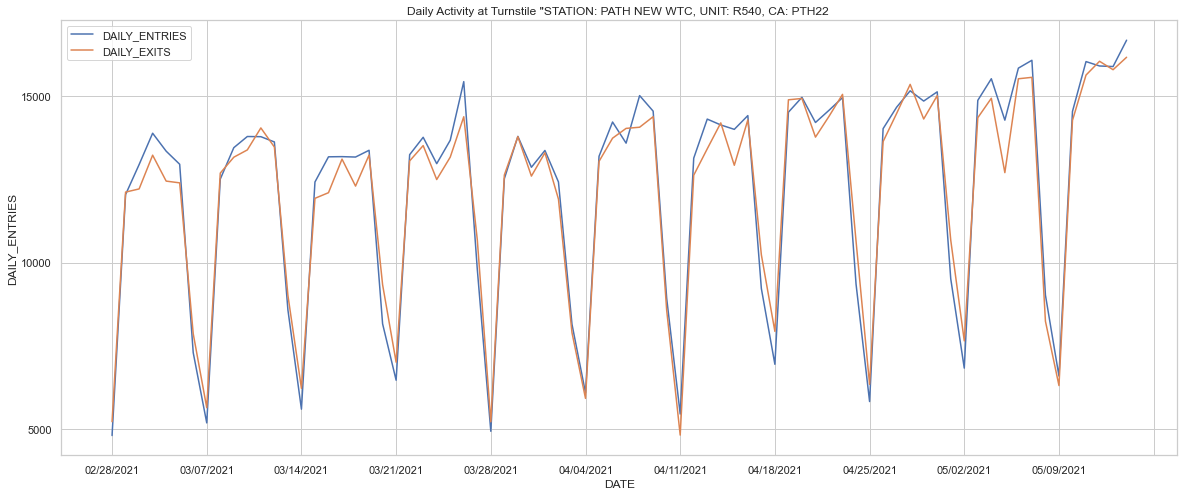

In [50]:
# Plot of DAILY ENTRIES and EXITS ant the busiest subway turnstile.

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=[20,8])
ax.plot(turnstile_max_daily_activity['DATE'],turnstile_max_daily_activity['DAILY_ENTRIES'], label='DAILY_ENTRIES')
ax.plot(turnstile_max_daily_activity['DATE'],turnstile_max_daily_activity['DAILY_EXITS'],label='DAILY_EXITS')
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_title('Daily Activity at Turnstile "STATION: PATH NEW WTC, UNIT: R540, CA: PTH22 ')
ax.set_ylabel('DAILY_ENTRIES')
ax.set_xlabel('DATE')
ax.legend()

In [51]:
# Notice that the DAILY_EXITS at any given station is within "DAILY_ENTRIES +/- 2000"
# Consider an anomaly to be DAILY_EXITS < (DAILY_ENTRIES)/4
# This is possible is the station is used infrequently by the residents, or it could be a tourist spot.
# Example, Museum of natural history, or MOMA. People will come to the museum via other means and enter the 
# station to go home or catch a connecting train

mask = (station_daily['DAILY_EXITS'] < 0.25*station_daily['DAILY_ENTRIES'])

In [52]:
station_daily_anomaly = station_daily[mask].sort_values('DAILY_ACTIVITY', ascending = False)
print('Total Number of Stations with anomaly:', station_daily_anomaly.STATION.count())
station_daily_anomaly.head()

Total Number of Stations with anomaly: 887


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
22688,NEWARK BM BW,04/09/2021,6258.0,887.0,7145.0
22686,NEWARK BM BW,04/07/2021,6285.0,770.0,7055.0
22699,NEWARK BM BW,04/20/2021,6423.0,436.0,6859.0
22671,NEWARK BM BW,03/23/2021,5885.0,896.0,6781.0
22684,NEWARK BM BW,04/05/2021,6213.0,522.0,6735.0


In [53]:
# See details of activities at the STATION with maximum anomaly

station_daily_anomaly = station_daily_anomaly.sort_values('DATE', ascending = True) # Sort by date
mask = (station_daily_anomaly['STATION'] == 'NEWARK BM BW')

In [54]:
station_daily_anomaly_station = station_daily_anomaly[mask]
station_daily_anomaly_station.head()

,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY
22648,NEWARK BM BW,02/28/2021,2699.0,349.0,3048.0
22649,NEWARK BM BW,03/01/2021,5132.0,725.0,5857.0
22650,NEWARK BM BW,03/02/2021,5287.0,623.0,5910.0
22651,NEWARK BM BW,03/03/2021,5426.0,641.0,6067.0
22652,NEWARK BM BW,03/04/2021,5279.0,788.0,6067.0


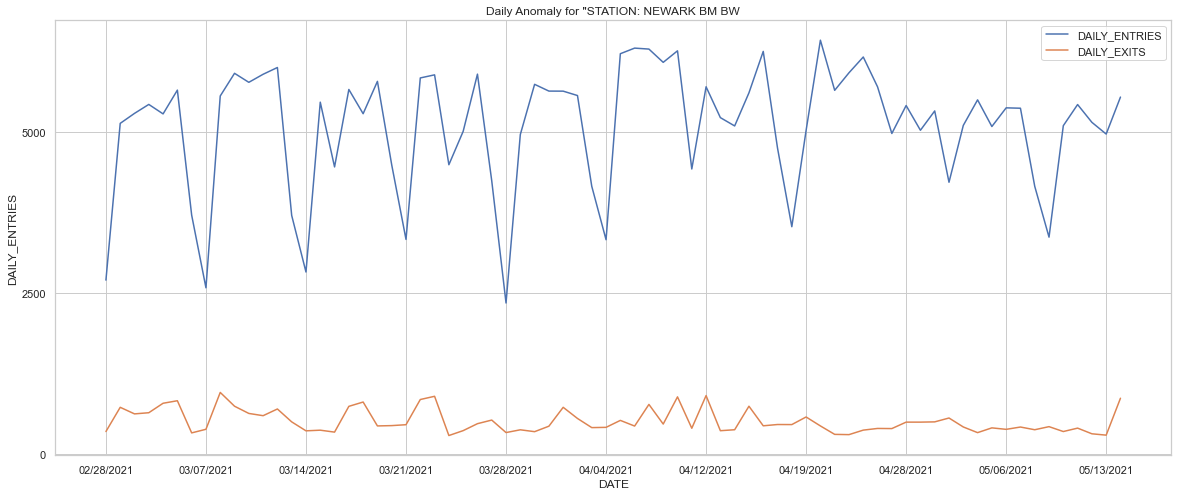

In [55]:
# Plot NEWARK BM BW station with noticeable anomaly.

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=[20,8])
ax.plot(station_daily_anomaly_station['DATE'],station_daily_anomaly_station['DAILY_ENTRIES'], label='DAILY_ENTRIES')
ax.plot(station_daily_anomaly_station['DATE'],station_daily_anomaly_station['DAILY_EXITS'],label='DAILY_EXITS')
ax.yaxis.set_major_locator(ticker.MultipleLocator(2500))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_title('Daily Anomaly for "STATION: NEWARK BM BW')
ax.set_ylabel('DAILY_ENTRIES')
ax.set_xlabel('DATE')
ax.legend()

In [56]:
# Analyzing the busiest subway station
#
# Observe Daily trend in DAILY Activity at the busiest station
# 34 ST-PENN STA	

# Create datetime valid date for station_daily
station_daily["DATE_DT"] = pd.to_datetime(station_daily.DATE , format="%m/%d/%Y")

# Using data from first week 02/28/2021 03/06/2021

mask1 = ( (station_daily["STATION"] == "34 ST-PENN STA") & 
         ( (station_daily["DATE_DT"].dt.date >= datetime.date(2021, 2, 27)) &
           (station_daily["DATE_DT"].dt.date <= datetime.date(2021, 3, 6)) ))

In [58]:
station_daily_busiest_wk1 = station_daily[mask1]
station_daily_busiest_wk1['DAY_IN_WEEK'] = station_daily_busiest_wk1['DATE_DT'].dt.day_name()
station_daily_busiest_wk1

<ipython-input-58-2a43c5973cfe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_daily_busiest_wk1['DAY_IN_WEEK'] = station_daily_busiest_wk1['DATE_DT'].dt.day_name()


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY,DATE_DT,DAY_IN_WEEK
4636,34 ST-PENN STA,02/28/2021,15591.0,22474.0,38065.0,2021-02-28,Sunday
4637,34 ST-PENN STA,03/01/2021,30538.0,38231.0,68769.0,2021-03-01,Monday
4638,34 ST-PENN STA,03/02/2021,31118.0,38407.0,69525.0,2021-03-02,Tuesday
4639,34 ST-PENN STA,03/03/2021,32126.0,38904.0,71030.0,2021-03-03,Wednesday
4640,34 ST-PENN STA,03/04/2021,31879.0,39796.0,71675.0,2021-03-04,Thursday
4641,34 ST-PENN STA,03/05/2021,31075.0,40579.0,71654.0,2021-03-05,Friday
4642,34 ST-PENN STA,03/06/2021,19395.0,30640.0,50035.0,2021-03-06,Saturday


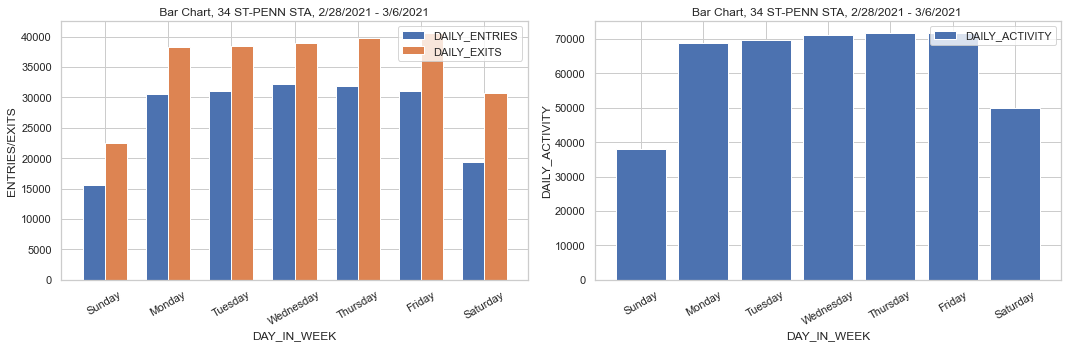

In [59]:
# Bar chart of DAY_IN_WEEK vs DAILY ENTRIES

sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,2,figsize=[15,5])

x_index = np.arange(station_daily_busiest_wk1.DAY_IN_WEEK.count())
wtmp1 = 0.35
ax[0].set_xticks(ticks=x_index)
rect1 = ax[0].bar(x_index - wtmp1/2,station_daily_busiest_wk1['DAILY_ENTRIES'],width=wtmp1,label='DAILY_ENTRIES') #color='orange'
rect2 = ax[0].bar(x_index + wtmp1/2,station_daily_busiest_wk1['DAILY_EXITS'],width=wtmp1,label='DAILY_EXITS') #color='blue'
ax[0].set_title(' Bar Chart, 34 ST-PENN STA, 2/28/2021 - 3/6/2021 ')
ax[0].set_ylabel('ENTRIES/EXITS')
ax[0].set_xlabel('DAY_IN_WEEK')
ax[0].set_xticklabels(station_daily_busiest_wk1['DAY_IN_WEEK'],rotation = 30, horizontalalignment = 'center' )
ax[0].legend()


#x_index = np.arange(tmp1.TIME.count())
#wtmp1 = 0.35
ax[1].set_xticks(ticks=x_index)
ax[1].bar(x_index,station_daily_busiest_wk1['DAILY_ACTIVITY'],label='DAILY_ACTIVITY') #color='orange'
ax[1].set_title('Bar Chart, 34 ST-PENN STA, 2/28/2021 - 3/6/2021 ')
ax[1].set_ylabel('DAILY_ACTIVITY')
ax[1].set_xlabel('DAY_IN_WEEK')
ax[1].set_xticklabels(station_daily_busiest_wk1['DAY_IN_WEEK'],rotation = 30, horizontalalignment = 'center' )
ax[1].legend()

fig.tight_layout()

In [60]:
# Using data from Second Week of May, 5/2/2021 - 5/8/2021

mask2 = ( (station_daily["STATION"] == "34 ST-PENN STA") & 
         ( (station_daily["DATE_DT"].dt.date >= datetime.date(2021, 5, 2)) &
           (station_daily["DATE_DT"].dt.date <= datetime.date(2021, 5, 8)) ))
station_daily_busiest_wk2 = station_daily[mask2]
station_daily_busiest_wk2['DAY_IN_WEEK'] = station_daily_busiest_wk2['DATE_DT'].dt.day_name()
station_daily_busiest_wk2

<ipython-input-60-ef647b7e7c73>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_daily_busiest_wk2['DAY_IN_WEEK'] = station_daily_busiest_wk2['DATE_DT'].dt.day_name()


,STATION,DATE,DAILY_ENTRIES,DAILY_EXITS,DAILY_ACTIVITY,DATE_DT,DAY_IN_WEEK
4699,34 ST-PENN STA,05/02/2021,20481.0,28979.0,49460.0,2021-05-02,Sunday
4700,34 ST-PENN STA,05/03/2021,34414.0,42659.0,77073.0,2021-05-03,Monday
4701,34 ST-PENN STA,05/04/2021,37045.0,44373.0,81418.0,2021-05-04,Tuesday
4702,34 ST-PENN STA,05/05/2021,35379.0,44545.0,79924.0,2021-05-05,Wednesday
4703,34 ST-PENN STA,05/06/2021,35527.0,45961.0,81488.0,2021-05-06,Thursday
4704,34 ST-PENN STA,05/07/2021,36478.0,48830.0,85308.0,2021-05-07,Friday
4705,34 ST-PENN STA,05/08/2021,25147.0,36847.0,61994.0,2021-05-08,Saturday


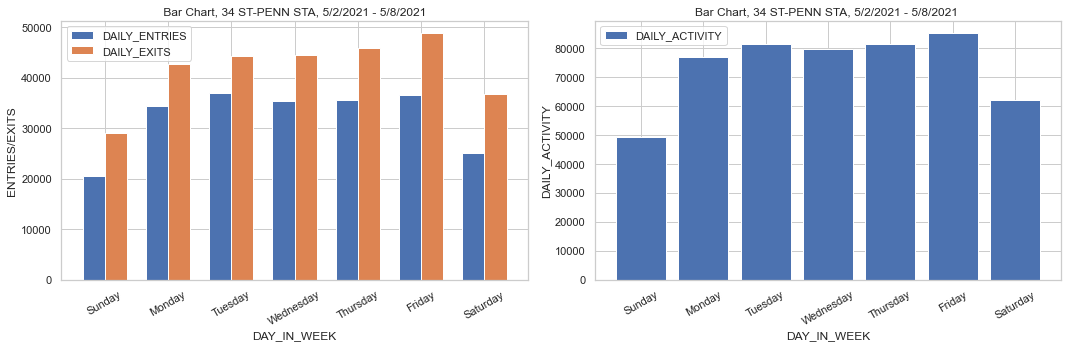

In [61]:
# Bar chart of DAY_IN_WEK vs DAILY ENTRIES

sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,2,figsize=[15,5])

x_index = np.arange(station_daily_busiest_wk2.DAY_IN_WEEK.count())
wtmp1 = 0.35
ax[0].set_xticks(ticks=x_index)
rect1 = ax[0].bar(x_index - wtmp1/2,station_daily_busiest_wk2['DAILY_ENTRIES'],width=wtmp1,label='DAILY_ENTRIES') #color='orange'
rect2 = ax[0].bar(x_index + wtmp1/2,station_daily_busiest_wk2['DAILY_EXITS'],width=wtmp1,label='DAILY_EXITS') #color='blue'
ax[0].set_title(' Bar Chart, 34 ST-PENN STA, 5/2/2021 - 5/8/2021 ')
ax[0].set_ylabel('ENTRIES/EXITS')
ax[0].set_xlabel('DAY_IN_WEEK')
ax[0].set_xticklabels(station_daily_busiest_wk2['DAY_IN_WEEK'],rotation = 30, horizontalalignment = 'center' )
ax[0].legend()


#x_index = np.arange(tmp1.TIME.count())
#wtmp1 = 0.35
ax[1].set_xticks(ticks=x_index)
ax[1].bar(x_index,station_daily_busiest_wk2['DAILY_ACTIVITY'],label='DAILY_ACTIVITY') #color='orange'
ax[1].set_title('Bar Chart, 34 ST-PENN STA, 5/2/2021 - 5/8/2021 ')
ax[1].set_ylabel('DAILY_ACTIVITY')
ax[1].set_xlabel('DAY_IN_WEEK')
ax[1].set_xticklabels(station_daily_busiest_wk2['DAY_IN_WEEK'],rotation = 30, horizontalalignment = 'center' )
ax[1].legend()

fig.tight_layout()

In [62]:
# Based on the last two group of graphs, weekdays are busier than weekends. 
# Thus, focus on weekdays

###########################################################################################
# PERFORM DATA CLEANING ON THE 4-HR (or on the interval) LEVEL                         ####
# Which 4-HR period is the busiest?                                                    ####
# Consider looking at the busiest station "34 ST-PENN STA "                            ####
# in the second week of May 5/03/2021 - 5/07/2021                                      ####
###########################################################################################

mta_data.head()

,CA,UNIT,SCP,STATION,LINE,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
2299529,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/14/2021,21:00:00,REGULAR,5554,548,2021-05-14 21:00:00
2299528,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/14/2021,17:00:00,REGULAR,5554,548,2021-05-14 17:00:00
2299527,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/14/2021,13:00:00,REGULAR,5554,548,2021-05-14 13:00:00
2299526,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/14/2021,09:00:00,REGULAR,5554,548,2021-05-14 09:00:00
2299525,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/14/2021,05:00:00,REGULAR,5554,548,2021-05-14 05:00:00


In [63]:
# Group by station and DATE. Sum all the entities

# Monday 05/03/2021
# Tuesday 05/04/2021
# Wednesday 05/05/2021
# Thursday 05/06/2021
# Friday 05/07/2021

maskm = ( (mta_data['STATION'] == '34 ST-PENN STA') &
          (mta_data["DATE"] == "05/03/2021")  )

mta_data_station_4hr = mta_data[maskm]
mta_data_station_4hr.head() 

,CA,UNIT,SCP,STATION,LINE,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
2021596,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,05/03/2021,22:00:00,REGULAR,68071062,18757246,2021-05-03 22:00:00
2021595,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,05/03/2021,18:00:00,REGULAR,68071038,18757214,2021-05-03 18:00:00
2021594,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,05/03/2021,14:00:00,REGULAR,68071004,18757127,2021-05-03 14:00:00
2021593,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,05/03/2021,10:00:00,REGULAR,68070959,18757036,2021-05-03 10:00:00
2021592,R142,R293,01-06-01,34 ST-PENN STA,123ACE,IRT,05/03/2021,06:00:00,REGULAR,68070952,18756975,2021-05-03 06:00:00


In [64]:
# Perform data cleaning on the MTA data RECORDED interval level. 

mta_data_station_4hr_sorted = (mta_data_station_4hr
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE", "TIME"],as_index=False)
                        [['ENTRIES','EXITS', "DATE_TIME"]].first())

mta_data_station_4hr_sorted[["PREV_TIME", "PREV_ENTRIES", "PREV_EXITS"]] = (mta_data_station_4hr_sorted
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["TIME", "ENTRIES", "EXITS"]]
                                                       .shift(1))
# Drop the rows for the earliest date in the df
mta_data_station_4hr_sorted.dropna(subset=["PREV_TIME"], axis=0, inplace=True)

# We saw backward rows during Daily operation. We should expect to see backward counters on the 4HR level.
(mta_data_station_4hr_sorted["ENTRIES"] - mta_data_station_4hr_sorted["PREV_ENTRIES"]).describe()

count    510.000000
mean      68.862745
std       89.275213
min      -39.000000
25%        5.000000
50%       41.000000
75%       97.000000
max      808.000000
dtype: float64

In [65]:
# Call the counter function for entries
#    Assuming one person per second per turnstile
#    This implies max(persons per 4HR) = 14,400

#    Using max of difference between ENTRIES and PREV_ENTRIES
#    05/03/2021 = 808

mta_data_station_4hr_sorted["4HR_ENTRIES"] = mta_data_station_4hr_sorted.apply(get_daily_counts, axis=1, max_counter=808) # max_counter_default = 1000000
mta_data_station_4hr_sorted.head()

,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,PREV_TIME,PREV_ENTRIES,PREV_EXITS,4HR_ENTRIES
1,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,04:00:00,246390,747459,2021-05-03 04:00:00,00:00:00,246390.0,747457.0,0.0
2,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,08:00:00,246442,747598,2021-05-03 08:00:00,04:00:00,246390.0,747459.0,52.0
3,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,12:00:00,246495,747786,2021-05-03 12:00:00,08:00:00,246442.0,747598.0,53.0
4,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,16:00:00,246530,747923,2021-05-03 16:00:00,12:00:00,246495.0,747786.0,35.0
5,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,20:00:00,246577,748126,2021-05-03 20:00:00,16:00:00,246530.0,747923.0,47.0


In [66]:
(mta_data_station_4hr_sorted["EXITS"] - mta_data_station_4hr_sorted["PREV_EXITS"]).describe()

count     510.000000
mean       86.121569
std       119.527528
min      -196.000000
25%        11.000000
50%        51.000000
75%       113.750000
max      1039.000000
dtype: float64

In [67]:
mta_data_station_4hr_sorted["4HR_EXITS"] = mta_data_station_4hr_sorted.apply(get_daily_counts_exit, axis=1, max_counter=1039) # max_counter_default = 1000000
mta_data_station_4hr_sorted.head()

,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,PREV_TIME,PREV_ENTRIES,PREV_EXITS,4HR_ENTRIES,4HR_EXITS
1,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,04:00:00,246390,747459,2021-05-03 04:00:00,00:00:00,246390.0,747457.0,0.0,2.0
2,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,08:00:00,246442,747598,2021-05-03 08:00:00,04:00:00,246390.0,747459.0,52.0,139.0
3,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,12:00:00,246495,747786,2021-05-03 12:00:00,08:00:00,246442.0,747598.0,53.0,188.0
4,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,16:00:00,246530,747923,2021-05-03 16:00:00,12:00:00,246495.0,747786.0,35.0,137.0
5,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,20:00:00,246577,748126,2021-05-03 20:00:00,16:00:00,246530.0,747923.0,47.0,203.0


In [68]:
mta_data_station_4hr_sorted['4HR_ACTIVITY'] = mta_data_station_4hr_sorted["4HR_ENTRIES"] \
                                          + mta_data_station_4hr_sorted["4HR_EXITS"]
mta_data_station_4hr_sorted.head()

,CA,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,PREV_TIME,PREV_ENTRIES,PREV_EXITS,4HR_ENTRIES,4HR_EXITS,4HR_ACTIVITY
1,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,04:00:00,246390,747459,2021-05-03 04:00:00,00:00:00,246390.0,747457.0,0.0,2.0,2.0
2,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,08:00:00,246442,747598,2021-05-03 08:00:00,04:00:00,246390.0,747459.0,52.0,139.0,191.0
3,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,12:00:00,246495,747786,2021-05-03 12:00:00,08:00:00,246442.0,747598.0,53.0,188.0,241.0
4,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,16:00:00,246530,747923,2021-05-03 16:00:00,12:00:00,246495.0,747786.0,35.0,137.0,172.0
5,N067,R012,00-00-00,34 ST-PENN STA,05/03/2021,20:00:00,246577,748126,2021-05-03 20:00:00,16:00:00,246530.0,747923.0,47.0,203.0,250.0


In [69]:
print(mta_data_station_4hr_sorted.shape)
mta_data_station_4hr_sorted['4HR_ENTRIES'].describe()

(510, 15)


count    510.000000
mean      69.211765
std       89.004372
min        0.000000
25%        5.000000
50%       41.000000
75%       97.000000
max      808.000000
Name: 4HR_ENTRIES, dtype: float64

In [70]:
# Group by 4HRS for all the turnstiles in the station for the current day
# Notice that the 4-HR loop is different for different turnstiles.

station_4HR = mta_data_station_4hr_sorted.groupby(["TIME"])[['4HR_ENTRIES','4HR_EXITS','4HR_ACTIVITY']] \
                .sum().reset_index()
station_4HR_1 = station_4HR.iloc[0:10:2]
station_4HR_1

,TIME,4HR_ENTRIES,4HR_EXITS,4HR_ACTIVITY
0,04:00:00,196.0,379.0,575.0
2,08:00:00,4430.0,4282.0,8712.0
4,12:00:00,5558.0,7500.0,13058.0
6,16:00:00,5765.0,8793.0,14558.0
8,20:00:00,7879.0,9931.0,17810.0


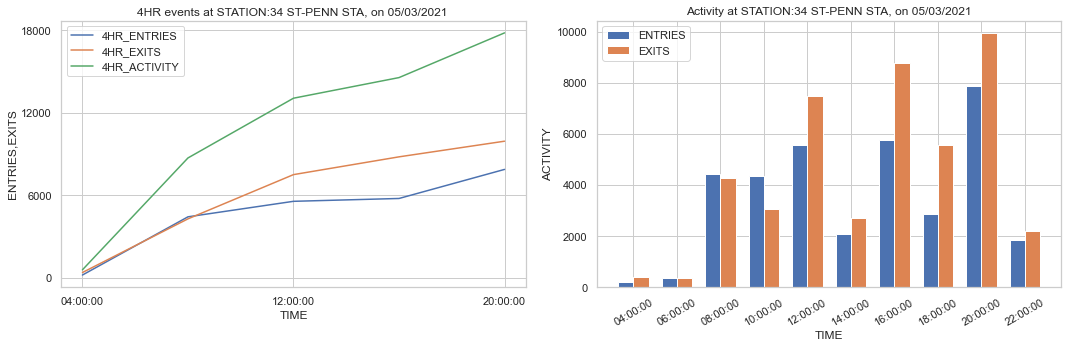

In [72]:
# 4 HR Plot

sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,2,figsize=[15,5])


ax[0].plot(station_4HR_1['TIME'],station_4HR_1['4HR_ENTRIES'], label='4HR_ENTRIES')
ax[0].plot(station_4HR_1['TIME'],station_4HR_1['4HR_EXITS'],label='4HR_EXITS')
ax[0].plot(station_4HR_1['TIME'],station_4HR_1['4HR_ACTIVITY'],label='4HR_ACTIVITY')
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(6000))
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(2))
ax[0].set_title('4HR events at STATION:34 ST-PENN STA, on 05/03/2021 ')
ax[0].set_ylabel('ENTRIES,EXITS')
ax[0].set_xlabel('TIME')
ax[0].legend()


x_index = np.arange(station_4HR.TIME.count())
wtmp1 = 0.35
ax[1].set_xticks(ticks=x_index)
#ax[1].hist(station_4HR['4HR_ACTIVITY'],bins=200, color='blue', edgecolor='black', label='4HR_ACTIVITY') #color='orange'
rect1 = ax[1].bar(x_index - wtmp1/2,station_4HR['4HR_ENTRIES'],width=wtmp1,label='ENTRIES') #color='orange'
rect2 = ax[1].bar(x_index + wtmp1/2,station_4HR['4HR_EXITS'],width=wtmp1,label='EXITS') 

ax[1].set_title('Activity at STATION:34 ST-PENN STA, on 05/03/2021')
ax[1].set_ylabel('ACTIVITY')
ax[1].set_xlabel('TIME')
ax[1].set_xticklabels(station_4HR['TIME'],rotation = 30, horizontalalignment = 'center' )
ax[1].legend()

fig.tight_layout()

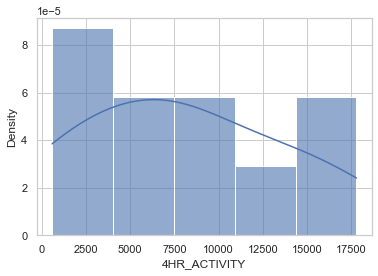

In [73]:
sns.set_theme(style='whitegrid')
sns.histplot(station_4HR['4HR_ACTIVITY'], kde=True,bins=5, stat='density', alpha=0.6);

In [74]:
# Import Median Income table into a Pandas dataframe
# Data from " https://data.cccnewyork.org/data/table/66/median-incomes#66/107/62/a/a  "

median_income = pd.read_csv('/Users/amyphillip/Desktop/Metis/project_1_nycsubway/MTA_Project_Final/median_income.csv')
median_income.head()

,ZIPCODE,HOUSEHOLD,FAMILIES,FAMILIES_CHILD,FAMILIES_NO_CHILD
0,Zip Code 10001,"$92,840.00","$122,776.00","$106,452.00","$132,545.00"
1,Zip Code 10002,"$36,982.00","$40,045.00","$42,054.00","$38,639.00"
2,Zip Code 10003,"$118,161.00","$183,787.00","$250,001.00","$153,480.00"
3,Zip Code 10004,"$190,223.00","$205,202.00","$244,000.00","$204,130.00"
4,Zip Code 10005,"$189,702.00","$241,094.00","$250,001.00","$202,042.00"


In [75]:
# Remove unecessary words and make the numbers column floating numbers

median_income['ZIPCODE'] = median_income.ZIPCODE.str.strip('Zip Code$ ')
median_income['HOUSEHOLD'] = median_income.HOUSEHOLD.str.strip('Zip Code$ ')
median_income['FAMILIES'] = median_income.FAMILIES.str.strip('Zip Code$ ')
median_income['FAMILIES_CHILD'] = median_income.FAMILIES_CHILD.str.strip('Zip Code$ ')
median_income['FAMILIES_NO_CHILD'] = median_income.FAMILIES_NO_CHILD.str.strip('Zip Code$ ')

# Replace commas in the numbers with an empty string

median_income['HOUSEHOLD'] = median_income.HOUSEHOLD.str.replace(',','')
median_income['FAMILIES'] = median_income.FAMILIES.str.replace(',','')
median_income['FAMILIES_CHILD'] = median_income.FAMILIES_CHILD.str.replace(',','')
median_income['FAMILIES_NO_CHILD'] = median_income.FAMILIES_NO_CHILD.str.replace(',','')

#columns = [column.strip('Zip Code$ ') for column in median_income.columns]

median_income.head()

,ZIPCODE,HOUSEHOLD,FAMILIES,FAMILIES_CHILD,FAMILIES_NO_CHILD
0,10001,92840.00,122776.00,106452.00,132545.00
1,10002,36982.00,40045.00,42054.00,38639.00
2,10003,118161.00,183787.00,250001.00,153480.00
3,10004,190223.00,205202.00,244000.00,204130.00
4,10005,189702.00,241094.00,250001.00,202042.00


In [76]:
# Convert to float data type

median_income['HOUSEHOLD'] =median_income.HOUSEHOLD.astype('float')
median_income['FAMILIES'] =median_income.FAMILIES.astype('float')
median_income['FAMILIES_CHILD'] =median_income.FAMILIES_CHILD.astype('float')
median_income['FAMILIES_NO_CHILD'] =median_income.FAMILIES_NO_CHILD.astype('float')
median_income.describe()

,HOUSEHOLD,FAMILIES,FAMILIES_CHILD,FAMILIES_NO_CHILD
count,187.000000,187.000000,187.000000,187.000000
mean,78808.304813,98041.213904,99129.406417,97637.556150
std,38327.232794,56970.638205,67038.396498,48916.557896
min,21447.000000,25429.000000,20114.000000,29907.000000
25%,54205.000000,60056.500000,52158.000000,65504.500000
50%,70900.000000,81250.000000,73354.000000,85298.000000
75%,94394.500000,114040.000000,126163.000000,112958.500000
max,250001.000000,250001.000000,250001.000000,250001.000000


In [77]:
# View list of top 5 busiest MTA stations

print(station_totals.head())

# Write the station_totals dataframe to a CSV file and add a column for the zipcode of the stations.
# Working csv file to be imported will be station_totals_zipcode.csv

station_totals.to_csv(r'/Users/amyphillip/Desktop/Metis/project_1_nycsubway/MTA_Project_Final/station_totals.csv', \
                      index=False, header=True)

             STATION  DAILY_ACTIVITY  AVG_DAILY_ACTIVITY
61    34 ST-PENN STA       5243508.0             68994.0
110            86 ST       3860315.0             50794.0
59   34 ST-HERALD SQ       3853764.0             50707.0
9             125 ST       3750103.0             49343.0
46             23 ST       3602981.0             47408.0


In [78]:
# Add the zipcodes of all the stations and read the new csv file into a pandas dataframe
# Import station_totals_zipcode.csv table into a Pandas dataframe
# Data from " https://data.cccnewyork.org/data/table/66/median-incomes#66/107/62/a/a  "

station_totals_zipcode = pd.read_csv('/Users/amyphillip/Desktop/Metis/project_1_nycsubway/MTA_Project_Final/station_totals_zipcode.csv')
station_totals_zipcode.head()

,STATION,DAILY_ACTIVITY,AVG_DAILY_ACTIVITY,ZIPCODE
0,34 ST-PENN STA,5243508.0,68994.0,10001
1,86 ST,3860315.0,50794.0,10028
2,34 ST-HERALD SQ,3853764.0,50707.0,10001
3,125 ST,3750103.0,49343.0,10027
4,23 ST,3602981.0,47408.0,10010


In [79]:
###########################################################################################
#   Working Data Frames are
#   -  station_totals [STATION , DAILY_ACTIVITY, AVG_DAILY_ACTIVITY]
#   -  median_income [ZIPCODE, HOUSEHOLD, FAMILIES, FAMILIES_CHILD, FAMILIES_NO_CHILD]
#   -  station_totals_zipcode [STATION, DAILY_ACTIVITY, AVG_DAILY_ACTIVITY, ZIPCODE]
###########################################################################################

# Create database engine

from sqlalchemy import create_engine

In [80]:
engine = create_engine("sqlite:///mta.db")

In [81]:
# Write station_totals dataframe to database

station_totals.to_sql('station_totals',engine,if_exists='fail')

In [82]:
# Write median income table to database

median_income.to_sql('median_income',engine,if_exists='fail')

In [83]:
# Write station_totals_zipcode dataframe to database

station_totals_zipcode.to_sql('station_totals_zipcode',engine,if_exists='fail')

In [84]:
# Query tables with 378 subway stations.
# 75%	94394.500000
# Set Household median income > 90,000
# 11 weeks = (77 -1) days.
# Assuming 1500000 daily activities at a station, Average daily activity = 19740
#
# MTA reported a total of 2.26 Million riders on 5/20/2021


target_stations_sql = pd.read_sql('SELECT st.STATION, stz.DAILY_ACTIVITY, stz.AVG_DAILY_ACTIVITY, m.ZIPCODE, m.HOUSEHOLD \
                                   FROM station_totals st \
                                   LEFT JOIN station_totals_zipcode stz ON st.DAILY_ACTIVITY = stz.DAILY_ACTIVITY \
                                   LEFT JOIN median_income m ON stz.ZIPCODE = m.ZIPCODE \
                                   WHERE st.AVG_DAILY_ACTIVITY > 19700 AND m.HOUSEHOLD >= 90000 \
                                   ORDER BY st.DAILY_ACTIVITY DESC;', engine)

In [85]:
target_stations_sql.rename(columns={'HOUSEHOLD':'MEDIAN_HOUSEHOLD_INCOME'},inplace=True)
target_stations_sql

,STATION,DAILY_ACTIVITY,AVG_DAILY_ACTIVITY,ZIPCODE,MEDIAN_HOUSEHOLD_INCOME
0,34 ST-PENN STA,5243508.0,68994.0,10001,92840.0
1,86 ST,3860315.0,50794.0,10028,122969.0
2,34 ST-HERALD SQ,3853764.0,50707.0,10001,92840.0
3,23 ST,3602981.0,47408.0,10010,132988.0
4,GRD CNTRL-42 ST,3396251.0,44688.0,10017,131045.0
5,14 ST-UNION SQ,3361178.0,44226.0,10003,118161.0
6,59 ST,3093916.0,40709.0,10023,132605.0
7,FULTON ST,3050608.0,40140.0,10007,224063.0
8,TIMES SQ-42 ST,2941607.0,38705.0,10036,95301.0
9,96 ST,2711305.0,35675.0,10025,91624.0


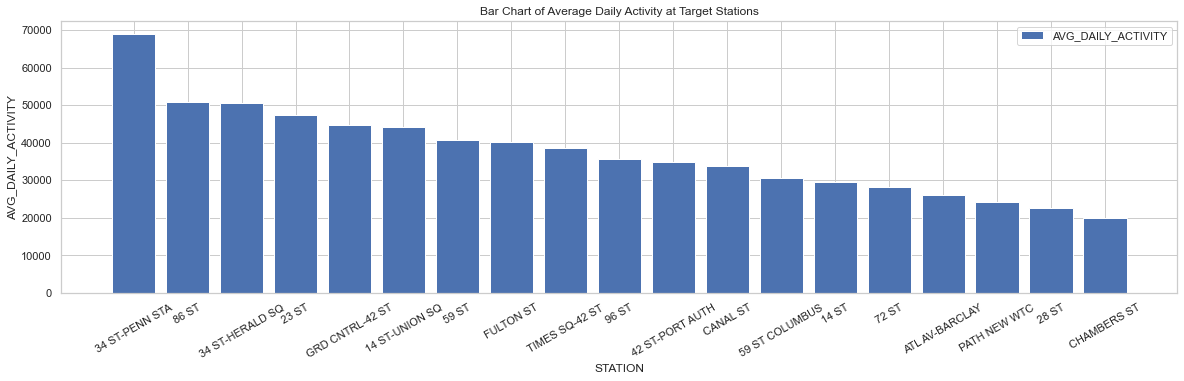

In [86]:
# Plot of average daily activity

fig, ax = plt.subplots(figsize=[20,5])

x_index = np.arange(target_stations_sql.STATION.count())
ax.set_xticks(ticks=x_index)
ax.bar(x_index,  target_stations_sql['AVG_DAILY_ACTIVITY'],label='AVG_DAILY_ACTIVITY') #color='orange'
ax.set_title('Bar Chart of Average Daily Activity at Target Stations')
ax.set_ylabel('AVG_DAILY_ACTIVITY')
ax.set_xlabel('STATION')
ax.set_xticklabels(target_stations_sql['STATION'],rotation = 30, horizontalalignment = 'center' )
ax.legend()

In [87]:
# Save target stations to csv file

target_stations_sql.to_csv(r'/Users/amyphillip/Desktop/Metis/project_1_nycsubway/target_stations_sql.csv', \
                      index=False, header=True)

In [97]:
#
#  Create an interactice GEOPLOT of NYC and highlight
#  Zipcodes with median income > $90,000.00 and average daily activity > 19700
#
#
# Reference a point in NYC using folium .Map

NYC_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)
NYC_map

In [98]:
# NYC zipcodes = https://chriswhong.github.io/plutoplus/
# Subway stations and zipcode = https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49
# NYC GeoJson cartographic file - https://github.com/fedhere/PUI2015_EC/blob/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson

nyc_zipcodes_json = "/Users/amyphillip/Desktop/Metis/project_1_nycsubway/MTA_Project_Final/geojson/nyc_zipcodes.geojson"

In [99]:
nyc_zipcodes_json_df = gpd.read_file(nyc_zipcodes_json)
nyc_zipcodes_json_df.head()

,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostalCode,Shape_Leng,Shape_Area,@id,geometry
0,1,11372,Jackson Heights,NY,Queens,36,081,0,20624.692317,2.016328e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.86942 40.74916, -73.89507 40.746..."
1,2,11004,Glen Oaks,NY,Queens,36,081,0,23002.816039,2.260653e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.71068 40.75004, -73.70869 40.748..."
2,3,11040,New Hyde Park,NY,Queens,36,081,0,15749.161511,6.269333e+06,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.70098 40.73890, -73.70309 40.744..."
3,4,11426,Bellerose,NY,Queens,36,081,0,35932.810639,4.941836e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.72270 40.75373, -73.72251 40.753..."
4,5,11365,Fresh Meadows,NY,Queens,36,081,0,38693.565676,6.938587e+07,http://nyc.pediacities.com/Resource/PostalCode...,"POLYGON ((-73.81089 40.72717, -73.81116 40.728..."


In [100]:
# Rename postalCode column to ZIPCODE

nyc_zipcodes_json_df = nyc_zipcodes_json_df.rename(columns = {'postalCode':'ZIPCODE'})

# Grap CIPCODE and geometry columns

nyc_zipcodes_json_df = nyc_zipcodes_json_df[['ZIPCODE','geometry']]
nyc_zipcodes_json_df.count()

ZIPCODE     262
geometry    262
dtype: int64

In [101]:
# View target_stations_sql
target_stations_sql.head()

,STATION,DAILY_ACTIVITY,AVG_DAILY_ACTIVITY,ZIPCODE,MEDIAN_HOUSEHOLD_INCOME
0,34 ST-PENN STA,5243508.0,68994.0,10001,92840.0
1,86 ST,3860315.0,50794.0,10028,122969.0
2,34 ST-HERALD SQ,3853764.0,50707.0,10001,92840.0
3,23 ST,3602981.0,47408.0,10010,132988.0
4,GRD CNTRL-42 ST,3396251.0,44688.0,10017,131045.0


In [102]:
# Merge nyc_zipcodes_json_df and target_stations_sql ON ZIPCODE

nyc_zipcode_station = nyc_zipcodes_json_df.merge(target_stations_sql,on='ZIPCODE', how='right')
nyc_zipcode_station.head()

,ZIPCODE,geometry,STATION,DAILY_ACTIVITY,AVG_DAILY_ACTIVITY,MEDIAN_HOUSEHOLD_INCOME
0,10001,"POLYGON ((-74.00827 40.75259, -74.00763 40.754...",34 ST-PENN STA,5243508.0,68994.0,92840.0
1,10001,"POLYGON ((-74.00827 40.75259, -74.00763 40.754...",34 ST-HERALD SQ,3853764.0,50707.0,92840.0
2,10028,"POLYGON ((-73.95992 40.78221, -73.94663 40.776...",86 ST,3860315.0,50794.0,122969.0
3,10010,"POLYGON ((-73.98775 40.74407, -73.98453 40.742...",23 ST,3602981.0,47408.0,132988.0
4,10017,"POLYGON ((-73.97765 40.75791, -73.96530 40.752...",GRD CNTRL-42 ST,3396251.0,44688.0,131045.0


In [103]:
# View data types of nyc_zipcode_station

nyc_zipcode_station.dtypes

ZIPCODE                      object
geometry                   geometry
STATION                      object
DAILY_ACTIVITY              float64
AVG_DAILY_ACTIVITY          float64
MEDIAN_HOUSEHOLD_INCOME     float64
dtype: object

In [104]:
# View Choropleth

nyc_target_station_map = folium.Map(location=[40.730610, -73.935242], zoom_start=10)  # tiles=None

folium.Choropleth(
       geo_data = nyc_zipcodes_json,
       name="choropleth",
       data = nyc_zipcode_station,
       columns = ['ZIPCODE', 'MEDIAN_HOUSEHOLD_INCOME'],
       key_on = 'feature.properties.postalCode',
       fill_color = 'YlOrRd',
       nan_fill_color='gray',
       legend_name ='Median household income ($)',
).add_to(nyc_target_station_map)

nyc_target_station_map.save("/Users/amyphillip/Desktop/Metis/project_1_nycsubway/MTA_Project_Final/nyc_target_station_map.html")
nyc_target_station_map

In [105]:
# https://vverde.github.io/blob/interactivechoropleth.html
#
# Use style function and highlight function for hover
# keep_in_front parameter for multiple map layers


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
ZIPC = folium.features.GeoJson(
    nyc_zipcode_station,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['ZIPCODE', 'MEDIAN_HOUSEHOLD_INCOME','STATION','AVG_DAILY_ACTIVITY'],
        aliases=['Zipcode: ','Median Household Income in $: ','Subway Station: ','Average Daily Activity: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
nyc_target_station_map.add_child(ZIPC)
nyc_target_station_map.keep_in_front(ZIPC)
folium.LayerControl().add_to(nyc_target_station_map)
nyc_target_station_map